In [1]:
% load_ext autoreload
% autoreload 2

%matplotlib inline

In [3]:
from dataset import *
from model import *

In [40]:
root = os.path.join("..", "data", "test")
anno_path = os.path.join(root, "test.csv")
data_test = fashion_ai_dataset(root, anno_path, is_train=False)

In [23]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from random import randint
from torchvision.transforms import ToPILImage, Normalize

def show_data(x, y, y_pred=None):
    to_img = ToPILImage()
    to_kpts = HeatmapToKeyPoints()
    
    def kpts_img(kpts, blur=True):
        img = torch.sum(kpts, 0, keepdim=True)
        img = to_img(img)
        img = np.array(img)
        if blur:
            img = cv2.GaussianBlur(img, (5, 5), 1)
        return img
    
    num_img = 2 if y_pred is None else 3
    plt.figure(figsize=(18, 18 // num_img))
    
    # undo the normalize by resnet
    mu = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    mu = -mu / std
    std = 1 / std
    normalize = Normalize(mu, std)
    plt.subplot(1, num_img, 1)
    plt.imshow(to_img(normalize(x)))
    
    y, mask, size = y
    y *= mask
    plt.subplot(1, num_img, 2)
    plt.imshow(kpts_img(y, blur=False))

    if y_pred is not None:
        kpts = to_kpts(y_pred.unsqueeze(0), mask.unsqueeze(0), size.unsqueeze(0))
        print(kpts)
        y_pred *= mask
        plt.subplot(1, num_img, 3)
        plt.imshow(kpts_img(y_pred))

In [24]:
model = CascadePyramidNet(24)
model.load_state_dict(torch.load("w.h5"))

RuntimeError: Error(s) in loading state_dict for CascadePyramidNet:
	Missing key(s) in state_dict: "out.weight", "out.bias". 
	Unexpected key(s) in state_dict: "out.0.weight", "out.0.bias". 

In [69]:
test_loader = data.DataLoader(data_test, batch_size=32, num_workers=6)

to_kpts = HeatmapToKeyPoints()
result = pd.DataFrame(columns=kpt_names)

model = model.cuda()
for x, (mask, size) in test_loader:
    x = x.cuda()
    mask = mask.cuda()
    size = size.cuda()
    with torch.no_grad():
        _, heatmap = model(x)
    bat_kpts = to_kpts(heatmap, mask, size)
    bat_kpts = bat_kpts.cpu().numpy()
    bat_kpts = list(map(lambda kpts : list(map(lambda kpt : "_".join(kpt.astype('str')), kpts)), bat_kpts))
    bat_kpts = pd.DataFrame(data=bat_kpts, columns=FashionAIDataset.kpt_names)
    result = result.append(bat_kpts,ignore_index=True)
    
df = data_test.dataset.df[["image_id", "image_category"]]
result = df.join(result)

In [70]:
print(result)

                                               image_id image_category  \
0     Images/blouse/155ee7793d159e227afb5f2e87ecf37b...         blouse   
1     Images/blouse/eb5e15695ba19647e22f3706eaff64f0...         blouse   
2     Images/blouse/176e9f307592aa532db64c46e03ebeb3...         blouse   
3     Images/blouse/a6a551e7da822ff06c2db9fc461a3e1d...         blouse   
4     Images/blouse/6ef9f5fa79be72ea6ce8a40c6b82712f...         blouse   
5     Images/blouse/52e536d423ad78f0a58f1c0c22916d28...         blouse   
6     Images/blouse/85182cb0cac7e4285e9dcd50338f18c0...         blouse   
7     Images/blouse/01f9983d1e84528ad8091804daf77937...         blouse   
8     Images/blouse/67da805d48aab90de9c3c53f7f18e71a...         blouse   
9     Images/blouse/46cff52bc34df1e65a1704319641b736...         blouse   
10    Images/blouse/9f344475e4af8d478ec3e822e51675e2...         blouse   
11    Images/blouse/9e8c29f51190111af1e332903ec89256...         blouse   
12    Images/blouse/3c2288c949b807a417

image_id          Images/blouse/e44dba9cb7a9cca78fff0bdeeaf41757...
image_category                                               blouse
image_path        ../data/test/Images/blouse/e44dba9cb7a9cca78ff...
Name: 1403, dtype: object


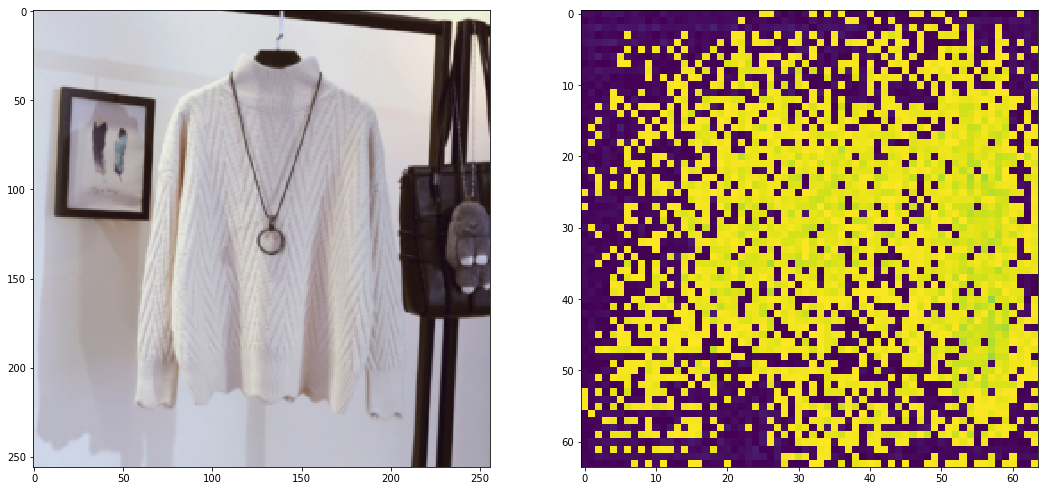

In [72]:
idx = randint(0, len(data_train) - 1)
#idx = 19629
print(data_train.dataset.df.iloc[idx])

x, y = data_train[idx]
heatmap = model(x.unsqueeze(0).cuda())[1].squeeze(0).cpu()
show_data(x, (heatmap, *y))